# Nanodegree Engenheiro de Machine Learning
## Projeto final
### Encontrando No-Show em Agendamentos de Consultas

----
## Exploração de Dados
### Carregando o Dataset
Primeiramente, no código a seguir, vamos importar as bibliotecas python necessárias ao projeto (outras serão importadas ao longo dos códigos). Aqui, também carregaremos o dataset do arquivo "2017.csv" para um dataframe geral que chamaremos de "appointments" e visualizaremos os registros das primeiras linhas.

In [1]:
""" Carrega o dataset e as bibliotecas básicas."""

import numpy as np
import pandas as pd
from time import time
from IPython.display import display

%matplotlib inline

# Carrega a base de dados para um dataframe.
appointments = pd.read_csv("2017.csv")

# Mostra os primeiros registros.
display(appointments.head(n=5))

,especialidad,edad,sexo,reserva_mes_d,reserva_mes_c,reserva_dia_d,reserva_dia_c,reserva_hora_d,reserva_hora_c,creacion_mes_d,creacion_mes_c,creacion_dia_d,creacion_dia_c,creacion_hora_d,creacion_hora_c,latencia,canal,tipo,show
0,76,66,1,1,0.87,1,0.62,18,0.00,12,1.00,4,-0.90,14,-0.87,18,1,1,0
1,76,66,1,1,0.87,1,0.62,19,0.26,12,1.00,5,-0.22,11,-0.97,17,1,1,0
2,18,35,1,1,0.87,1,0.62,15,-0.71,12,1.00,2,-0.22,10,-0.87,20,3,1,0
3,51,44,2,1,0.87,1,0.62,19,0.26,11,0.87,2,-0.22,8,-0.50,34,1,1,0
4,76,72,2,1,0.87,1,0.62,12,-1.00,12,1.00,5,-0.22,10,-0.87,17,1,1,0


### Explorando as features
A seguir, temos as descrições das colunas do dataset segundo o autor.
- **especialidad**, tipo de especialista para a consulta. Ou seja, dematologista, oftalmologista, etc;
- **edad**, idade;
- **sexo**, sexo, 1=Homem, 2=Mulher;
- **reserva_mes_d**, valor discreto para o mês da consulta, 1 = Jan... 12 = Dez;
- **reserva_mes_c**, valor constínuo para o mês da consulta, a fórmula é COS(2*reserva_mes_d*Pi/12);
- **reserva_dia_d**, valor discreto para o dia da semana da consulta, 1 = Seg ... 7 = Sab;
- **reserva_dia_c**, valor contínuo do dia da semana da consulta, a fórmula é COS(2*reserva_dia_d*Pi/7);
- **reserva_hora_d**, valor discreto para a hora da consulta, 0h ... 23h;
- **reserva_hora_c**, valor contínuo para a hora da consulta, a fórmula é COS(2*reserva_hora_d*Pi/24);
- **creacion_mes_d**, valor discreto para o mês em que o agendamento foi criado, 1 = Jan ... 12 = Dez;
- **creacion_mes_c**, valor contínuo para o mês em que o agendamento foi criado, a fórmula é COS(2*creacion_mes_d*Pi/12);
- **creacion_dia_d**, mesmo que reserva_dia_d, mas considerando o dia em que o agendamento foi criado;
- **creacion_dia_c**, mesmo que reserva_dia_c, mas considerando o dia em que o agendamento foi criado;
- **creacion_hora_d**, hora em que o agendamento foi criada, 0h ... 23h;
- **creacion_hora_c**, valor contínuo para creacion_hour_d, a fórmula é COS(2*creacion_hora_d*Pi/24);
- **latencia**, número de dias entre a consulta e a data de criação do agendamento;
- **canal**, canal usado para criação da consulta, 1 = call center, 2 = Personal, 3 = Web;
- **tipo**, tipo de consulta, 1 = consulta medica, 2 = procedimento médico;
- **show**, confirmação da consulta, 0 = no show, 1 = show.

A última coluna será nosso **rótulo** de resultado binário (show=1 e no-show=0), enquanto as outras serão nossas **features**. Duas coisas nos chama a atenção ao observar as descrições das features e seus dados:
1. Todos os valores já são do tipo núméricos, o que facilita nosso trabalho;
2. Os valores de algumas features são resultados calculados de outras e usam como base a função cossenóide.

Temos as 'features' '**reserva_mes_c**', '**reserva_dia_c**', '**reserva_hora_c**', '**creacion_mes_c**', '**creacion_dia_c**' e '**creacion_hora_c**' de **valores calculados e contínuos** e, ainda, '**latencia**' como de **valores contínuos**, mesmo sendo do tipo inteiro. As outras 'features' são todas limitadas a uma faixa ou lista definida, sendo, portanto, de **valores discretos**.

Quanto a **valores nulos ou brancos**, podemos observar a impressão do resultado do código a seguir. Nele, são contados os dados nulos e brancos através do comando 'appointments.isnull().sum()' e agrupados por feature.

In [7]:
""" Mostra a quantidade de dados brancos e nulos no dataset."""

null_nan = list(appointments.isnull().sum())

values_null_nan = {'Nome da Feature/Rótulo': appointments.columns,
            'Qtd. de brancos e nulos': null_nan}
display(pd.DataFrame(data=values_null_nan))

,Nome da Feature/Rótulo,Qtd. de brancos e nulos
0,especialidad,0
1,edad,0
2,sexo,0
3,reserva_mes_d,0
4,reserva_mes_c,0
5,reserva_dia_d,0
6,reserva_dia_c,0
7,reserva_hora_d,0
8,reserva_hora_c,0
9,creacion_mes_d,0


Observando a tabela acima, constatamos que não há dados brancos e nulos no dataset.

### Estatística do dataset
Uma investigação superficial do dataset determinará quantos pacientes se encaixam em qualquer grupo e nos informará sobre a porcentagem dessas pessoas que não compareceram à consulta. No código abaixo, são calculos o seguinte:
- O número total de registros, 'num_records';
- O número total de pacientes que compareceram às consultas, 'num_show'.
- O número total de pacientes que não compareceram às consultas, 'num_no_show'.
- A porcentagem de pacientes que compareceram às consultas, 'greater_percent'.

In [8]:
""" Estatística superficial do dataset."""

# O número total de registros.
num_records = appointments.shape

# O número total de pacientes que compareceram às consultas.
num_show = appointments[appointments['show'] == 1 ].shape

# O número total de pacientes que não compareceram às consultas.
num_no_show = appointments[appointments['show'] == 0 ].shape

# A porcentagem de pacientes que compareceram às consultas.
greater_percent = float(num_show[0]) / float(num_records[0]) * 100

# A porcentagem de pacientes que não compareceram às consultas.
smaller_percent = float(num_no_show[0]) / float(num_records[0]) * 100

# Imprime os resultados.
print("Número total de registros: {}".format(num_records))
print("Pacientes que compareceram: {}".format(num_show[0]))
print("Pacientes que não compareceram: {}".format(num_no_show[0]))
print("Percentual de pacientes que compareceram: {:.2f}%".format(greater_percent))
print("Percentual de pacientes que não compareceram: {:.2f}%".format(smaller_percent))

Número total de registros: (61214, 19)
Pacientes que compareceram: 48346
Pacientes que não compareceram: 12868
Percentual de pacientes que compareceram: 78.98%
Percentual de pacientes que não compareceram: 21.02%


----
## Visualização Exploratória
Sobre as **features de campos calculados com função cossenóide**, o uso dessa função num determinado intervalo de tempo dá pesos maiores no início e fim e peso menor no meio desse intervalo. Por exemplo, dentro de uma semana qualquer, os primeiros e os últimos dias terão valores maiores e os dias intermediários terão valores menores. o código a seguir mostra os gráficos que relacionam os valores das features discretas 'reserva_mes_d', 'reserva_dia_d', 'reserva_hora_d' com suas features cóntínuos correspondentes 'reserva_mes_c', 'reserva_dia_c', 'reserva_hora_c', respectivamente.

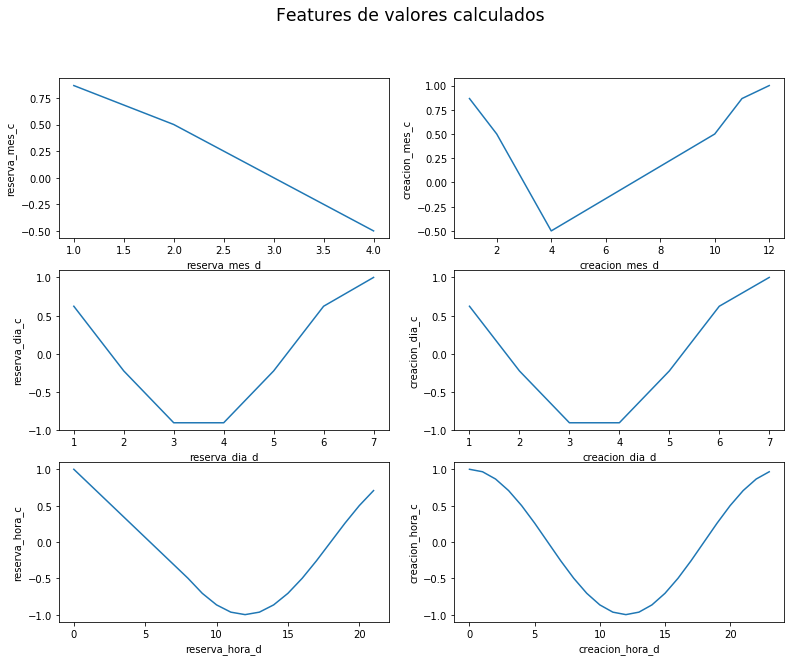

In [9]:
""" Plota os valores das features calculadas."""

import matplotlib.pyplot as plt
import math

fig_calculateds = plt.figure(figsize = (13,10))

# Partes dos nomes das features calculadas.
parts_features_calculateds = ['reserva_mes', 'creacion_mes',
                              'reserva_dia', 'creacion_dia',
                              'reserva_hora', 'creacion_hora']
# Número de possibilidades em cada feature calculada, respectivamente.
# {janeiro=1, fevereiro=2, ..., dezembro=12} >> total = 12.
# {domingo=1, segunda-feira=2, ..., sábado=7} >> total = 7.
# {1h, 2h, ..., 23h} >> total = 24.
num_poss = [12, 12, 7, 7, 24, 24]

# plotagem de cada feature calculada.
for i, feature in enumerate(parts_features_calculateds):
    interval = list(set(appointments[feature+'_d']))
    interval_calc = []
    for j in interval:
        interval_calc.append(round(math.cos(2*j*math.pi/num_poss[i]), 3))
    ax = fig_calculateds.add_subplot(3, 2, i+1)
    ax.plot(interval, interval_calc)
    ax.set(xlabel=feature+'_d', ylabel=feature+'_c')

fig_calculateds.suptitle("Features de valores calculados", fontsize='xx-large')
plt.show()

O conjunto de valores da feature 'reserva_dia_d' tem os mesmos elementos do conjunto de 'creaction_dia_d', enquanto 'reserva_mes_d' e 'reserva_hora_d' têm menos elementos em relação a 'creaction_mes_d' e 'creaction_hora_d', respectivamente.

As feature de campos calculados e a 'latencia' são de valores continuos. O código a seguir resulta no gráfico de distribuição de todas as features de valores contínuos. Abaixo, segue o histograma de cada uma delas para observações de valores discrepantes.

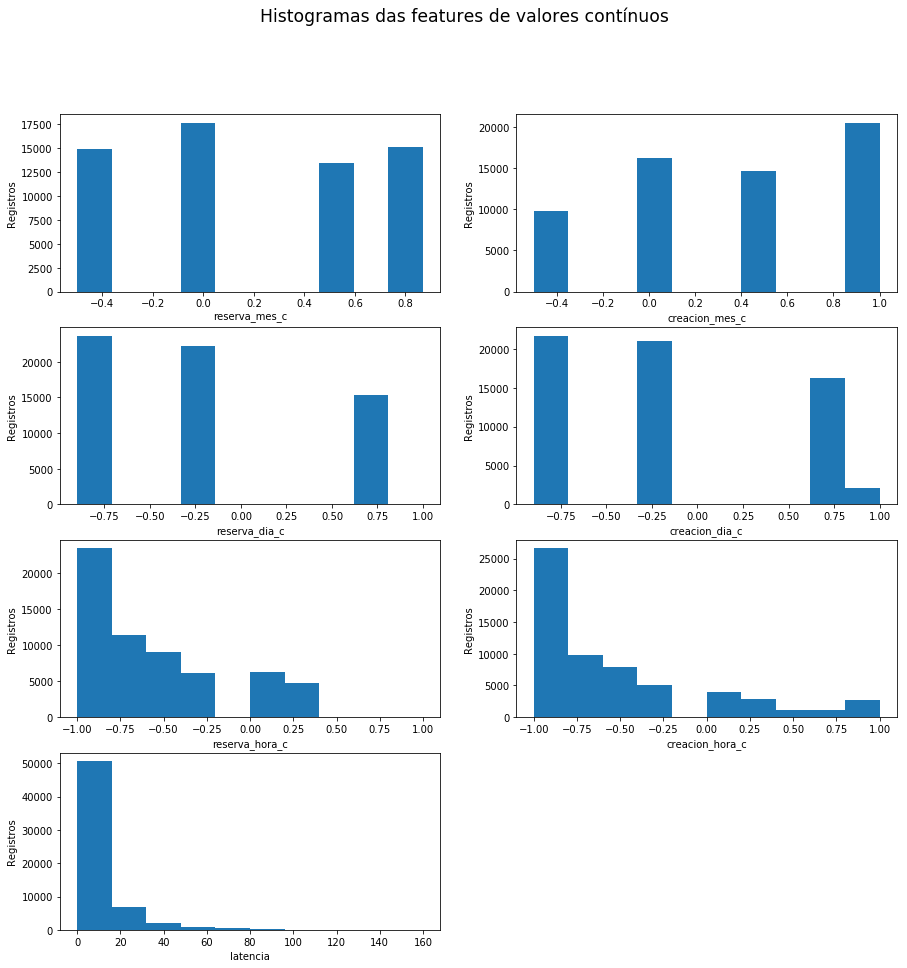

In [5]:
""" Mostra o histograma das features de valores contínuos com discrepâncias."""

# Nomes das features contínuas.
features_continuous = ['reserva_mes_c', 'creacion_mes_c',
                      'reserva_dia_c', 'creacion_dia_c',
                      'reserva_hora_c', 'creacion_hora_c',
                      'latencia']

def distribution(data, features_names, titulo_sup):
    fig_continuous = plt.figure(figsize = (15,15))

    
    
    # Plotagem de cada feature calculada.
    for i, feature in enumerate(features_names):
        ax = fig_continuous.add_subplot(4, 2, i+1)
        ax.hist(data[feature])
        ax.set(xlabel=feature, ylabel="Registros")

    # Plotagem de todos os histigramas
    fig_continuous.suptitle(titulo_sup, fontsize='xx-large')
    plt.show()

    # Visualização dos histogramas com os valores brutos.
titulo_superior = "Histogramas das features de valores contínuos"
distribution(appointments, features_continuous, titulo_superior)

Observando os histogramas, as features 'reserva_mes_c', 'creacion_mes_c', 'reserva_dia_c' e 'creacion_dia_c' têm saltos significativos de concentrações, mas com quantidade de registros mais equilibradas. Já as features 'reserva_hora_c', 'creacion_hora_c' e 'latência' tem outlies, alguns registros muito distantes da área de maior concentração.

----
## Algoritmos e Técnicas
Neste projeto, a classificação de novos pacientes tendo como únicos resultados o comparecimento ou não à consulta, é uma solução de **aprendizado supervisionado**, pois esse modelo é treinado a partir de registros com seus resultados no rótulo do dataset, onde já temos as duas classes definidas ('show=1' e 'show=0'). Para aplicar esse tipo de aprendizado, vamos utilizar a biblioteca '**sklearn**' que compõe vários algoritmos de aprendizagem.

Antes de aplicar os algoritmos de classificação, é importante saber se os dados devem ser transformados. Para o dataset deste projeto, dois processos de transformação importantes para o bom resultado dos algoritmos devem ser feitos na seguinte sequência:
- **Transformação de features contínuos enviesados**, para diminuir os efeitos de discrepâncias nos dados, como 'outlies'. Isso será feito aplicando a técnica de **logaritmização** dos dados das 'features' contínuas com o uso da função '**log()**' da biblioteca '**numpy**'.
- **Normalização de** '**features**' **numéricas**, aplicando a técnica de  **redimensionamento dos dados** numa mesma escala, neste caso, entre '0.0' e '1.0', garantindo que cada 'feature' seja tratado igualmente ao aplicar os algoritmos. Isso será feito com a função de ajuste '**fit_transform()**' de um objeto '**MinMaxScaler**' da biblioteca '**sklearn.preprocessing**'.

Em seguida, devemos aplicar a **divisão dos dados**, separando uma parte dos registros para **treinamento** e outra para **teste**. Uma proporção de divisão muito utilizada, com ótimo desempenho, que também vamos adotar, é a de **80% para treinamento** e **20% para teste**. é importante que os registros escolhidos para cada parte seja embaralhado, evitando resultados tendenciosos. Esse embaralhamento e separação serão feitos com a função '**train_test_split**' da biblioteca '**sklearn.model_selection**'. O valor do parâmetro '**random_state**' dessa função deverá ser o mesmo na inicialização dos classificadores que tenham também esse parâmetro.

O passo seguinte é fazer o **balanceamento dos dados**, para deixar por igual a proporção de registros de resultado '(show=1)=78.979%' com o de '(show=0)=21.021%' e, com isso, melhorar o modelo aprendido. Essa técnica deverá ser **aplicada apenas no 'dataset' de treinamento**, de forma a evitar o vício durante o treinamento do classificador tendendo a levar o resultado mais para o lado de maior proporção, evitando, assim, o sobreajuste. Quanto mais dados para treinar o classificador, maior será a precisão na predição. Por isso, para deixar por igual as percentagens, não vamos diminuir o conjunto de registros com resultados pertencentes à clase de maior proporção 'show=1'. Portanto, será feito o aumento de registros com resultados 'show=0' com dados sintéticos através da técnica de '**oversampling**'. Isso será feito com a função de ajuste '**fit_resample**' de um objeto '**SMOTE**' da biblioteca '**imblearn.over_sampling**'.

Não é necessário transformar valores categóricos, pois todos os dados são numéricos.

Em relação aos algoritmos de aprendizado supervisionado que podemos utilizar neste projeto, devemos levar em consideração duas características:
- Possui dados discretos e contínuos no dataset;
- São 18 features e 1 rótulo, o que pode deixar o processamento mais lento.

Essas características nos sugere o uso dos seguintes algoritmos de classificação de apredizado supervisionado que serão nossos '**learners**' e vamos aplicar neste projeto:
- '**Gaussian Naive Bayes**', que trabalha bem com valores contínuos e que tem processamento rápido.
- '**Classifier Tree**', que trabalha bem com valores discretos e contínuos.
- '**Random Florest**', como um '**Ensemble Method**', que trabalha bem com valores discretos e contínuos e com muitas features.

Verificaremos também se são necessárias todas ou parte das features, acompanhando o '**delay**' do classificador com a intenção de aumentar a velocidade de processamento sem perdas significativas nas métricas de previsão. As features serão escolhidas pelos seus valores de **importância no resultado** medido através do atributo 'feature_importance_' presente em alguns classificadores da biblioteca 'sklearn'.

----
## Pré-Processamento de Dados
Primeiramente, faremos aqui uma separação entre as features e o rótulo com seus dados na forma bruta, inicial. O código a seguir faz esse processo.

In [6]:
# Dividindo os dados em recursos e rótulo.
show_raw = appointments['show']
features_raw = appointments.drop('show', axis = 1)

### Transformação de features contínuos enviesados
No dataset deste projeto, sete features são de valores contínuos. Segundo os gráficos de histogramas da seção de Visualização Exploratória, três deles ('reserva_hora_c', 'creacion_hora_c' e 'latencia') apresenta pequenos grupos de valores distantes das concentrações, ou seja, **outlies**. Para diminuir as interferências nos resultados por conta dessas discrepâncias, vamos aplicar a **logaritmização** nos dados dessas features. Devemos tomar cuidado ao aplicar esta transformação, pois o logaritmo de números menores ou iguais a '0' são indefinidos. Para resolver isso, podemos deslocar todos os números dessas features discrepantes, somando com um número fixo tal que o menor número (o maior negativo) dentre todos os dados da features contínuas se torne positivo e maior que zero. A seguir, o código executa esse processo, descobrindo qual o menor valor dentre as features discrepantes para determinar o valor a ser adicionado a fim de fazer a logaritmização.

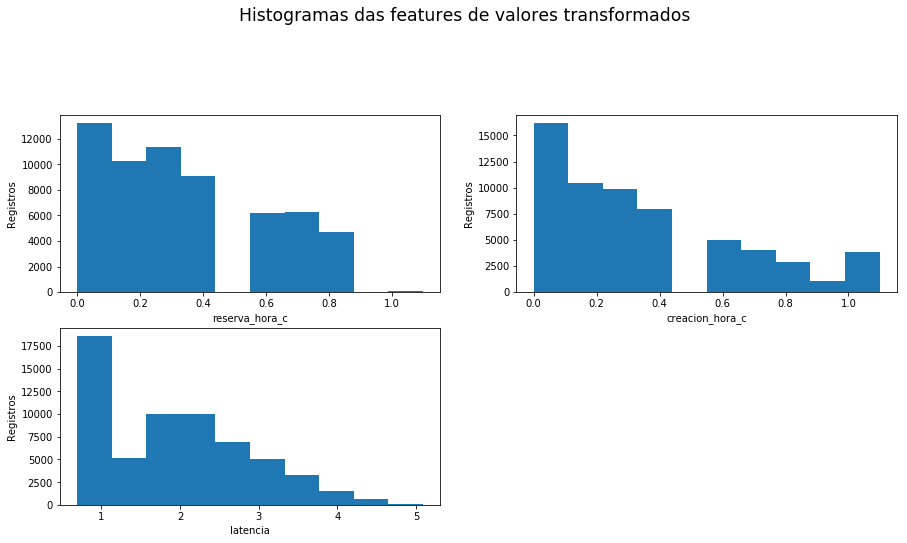

In [7]:
""" Transformação logarítmica das 'features' de valores discrepantes."""
# Nomes das features contínuas discrepantes.
skewed = ['reserva_hora_c', 'creacion_hora_c', 'latencia']

# Descobrindo o menor valor dentre as features discrepantes.
value_skewed_min = np.inf
for i, feature in enumerate(skewed):
    value_min = features_raw[feature].min()
    if value_min < value_skewed_min:
        value_skewed_min = value_min

# Logaritmizando os dados das features discrepantes.
features_log_transformed = pd.DataFrame(data=features_raw)
features_log_transformed[skewed] = features_log_transformed[skewed]\
                                    .apply(lambda x: np.log(x+abs(value_skewed_min)+1))

# Visualização dos histogramas com os valores transformados.
titulo_superior = "Histogramas das features de valores transformados"
distribution(features_log_transformed, skewed, titulo_superior)

### Normalização de features numéricas
Vamos aplicar um dimensionamento, ou escalonamento, em todas as features, pois todas são numéricas. Fazer isso aos dados não altera a forma da distribuição de cada feature. No entanto, a normalização garante que cada recurso seja tratado igualmente ao aplicar os classificadores. O código a seguir faz essa normalização em todas as features para uma escala entre '0.0' e '1.0'. Isso é feito com a função 'MinMaxScaler' da biblioteca 'sklearn.preprocessing'.

In [8]:
""" Normalização das features numéricas."""

from sklearn.preprocessing import MinMaxScaler

# Inicializa um escalonador.
scaler = MinMaxScaler() # default=(0, 1)

# Aplicando o escalonador.
features_log_minmax_transform = pd.DataFrame(data=features_log_transformed)
features_names = features_log_minmax_transform.columns
features_log_minmax_transform[features_names] = \
            scaler.fit_transform(features_log_transformed[features_names])

# Mostrar um exemplo de um registro com dimensionamento aplicado.
display(features_log_minmax_transform.head(n=10))

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,especialidad,edad,sexo,reserva_mes_d,reserva_mes_c,reserva_dia_d,reserva_dia_c,reserva_hora_d,reserva_hora_c,creacion_mes_d,creacion_mes_c,creacion_dia_d,creacion_dia_c,creacion_hora_d,creacion_hora_c,latencia,canal,tipo
0,0.369458,0.653465,0.0,0.0,1.0,0.0,0.8,0.857143,0.630930,1.000000,1.000000,0.500000,0.000000,0.608696,0.111247,0.523976,0.0,0.0
1,0.369458,0.653465,0.0,0.0,1.0,0.0,0.8,0.904762,0.742177,1.000000,1.000000,0.666667,0.357895,0.478261,0.026906,0.512304,0.0,0.0
2,0.083744,0.346535,0.0,0.0,1.0,0.0,0.8,0.714286,0.231785,1.000000,1.000000,0.166667,0.357895,0.434783,0.111247,0.545665,1.0,0.0
3,0.246305,0.435644,1.0,0.0,1.0,0.0,0.8,0.904762,0.742177,0.909091,0.913333,0.166667,0.357895,0.347826,0.369070,0.657732,0.0,0.0
4,0.369458,0.712871,1.0,0.0,1.0,0.0,0.8,0.571429,0.000000,1.000000,1.000000,0.666667,0.357895,0.434783,0.111247,0.512304,0.0,0.0
5,0.369458,0.207921,0.0,0.0,1.0,0.0,0.8,0.714286,0.231785,1.000000,1.000000,0.000000,0.800000,0.478261,0.026906,0.473197,0.0,0.0
6,0.369458,0.811881,0.0,0.0,1.0,0.0,0.8,0.523810,0.026906,1.000000,1.000000,0.000000,0.800000,0.521739,0.000000,0.555780,0.5,0.0
7,0.083744,0.267327,1.0,0.0,1.0,0.0,0.8,0.476190,0.111247,0.909091,0.913333,0.166667,0.357895,0.826087,0.742177,0.657732,0.0,0.0
8,0.098522,0.108911,1.0,0.0,1.0,0.0,0.8,0.904762,0.742177,1.000000,1.000000,0.666667,0.357895,0.739130,0.504168,0.583679,1.0,0.0
9,0.083744,0.277228,1.0,0.0,1.0,0.0,0.8,0.428571,0.231785,0.909091,0.913333,0.000000,0.800000,0.521739,0.000000,0.736993,1.0,0.0


### Divisão dos dados
Com todas as features normalizadas, agora dividiremos os dados (features e rótulo) em conjuntos de **treinamento** e **teste**. 80% dos dados serão usados para treinamento e 20% para teste. Isso é feito com a função 'train_test_split' da biblioteca 'sklearn.model_selection' que embaralha e divide os dados numa proporção determinada. O código a seguir executa esse processo.

In [9]:
""" Divisão dos dados para treinamento e teste."""

from sklearn.model_selection import train_test_split

# Divide os dados das features e rótulo em conjuntos de treinamento e de teste.
X_train, X_test, y_train, y_test = train_test_split(features_log_minmax_transform, 
                                                    show_raw, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("O conjunto de treinamento tem {} amostras.".format(X_train.shape[0]))
print("O conjunto de teste tem {} amostras.".format(X_test.shape[0]))

O conjunto de treinamento tem 48971 amostras.
O conjunto de teste tem 12243 amostras.


### Balanceamento dos dados
Agora, já com os dados para treinamento, podemos fazer o balanceamento nesse conjuto. A técnica que usaremos é a **Synthetic Minority Oversampling Technique (SMOTE)**, que aplica um **oversampling**. Essa técnica adiciona dados sintéticos entre os registros da classe minoritária, no caso 'show=0', até deixar na proporção próxima ou igual a da majoritária, com 'show=1'. O código a seguir executa esse processo usando a função 'SMOTE' da biblioteca 'imblearn.over_sampling' e mostra a nova proporção entre as classes, nos dando o **conjunto final de dados de treinamento**.

In [10]:
""" Fazendo o balanceamento dos dados e Mostrando novamente
a estatística básica para comprovar o balanceamento."""

from imblearn.over_sampling import SMOTE

# Fazendo o balanceamento para determinar o conjunto final de dados de treinamento.
X_train_SMOTE, y_train_resampled = SMOTE().fit_resample(X_train, y_train)
X_train_resampled = pd.DataFrame(data=X_train_SMOTE, columns=X_train.columns)

# O número total de pacientes entre registros reais e sintéticos no conjunto de treinamento.
num_records_train_resampled = len(y_train_resampled)

# O número total de pacientes que compareceram às consultas
# entre registros reais e sintéticos no conjunto de treinamento.
num_show_train_resampled = list(y_train_resampled).count(1)

# O número total de pacientes que não compareceram às consultas
# entre registros reais e sintéticos no conjunto de treinamento.
num_no_show_train_resampled = list(y_train_resampled).count(0)

# A porcentagem de pacientes que compareceram às consultas
# entre registros reais e sintéticos no conjunto de treinamento.
percent_show_train_resampled = float(num_show_train_resampled) / float(num_records_train_resampled) * 100

# A porcentagem de pacientes que não compareceram às consultas
# entre registros reais e sintéticos no conjunto de treinamento.
percent_no_show_train_resampled = float(num_no_show_train_resampled) / float(num_records_train_resampled) * 100

# Imprime os resultados.
print("Número total de registros no cunjunto de dados de treinamento: {}"\
      .format(num_records_train_resampled))
print("Pacientes que compareceram no cunjunto de dados de treinamento: {}"\
      .format(num_show_train_resampled))
print("Pacientes que não compareceram no cunjunto de dados de treinamento: {}"\
      .format(num_no_show_train_resampled))
print("Percentual de pacientes que compareceram no cunjunto de dados de treinamento: {:.2f}%"\
      .format(percent_show_train_resampled))
print("Percentual de pacientes que não compareceram no cunjunto de dados de treinamento: {:.2f}%"\
      .format(percent_no_show_train_resampled))

Número total de registros no cunjunto de dados de treinamento: 77544
Pacientes que compareceram no cunjunto de dados de treinamento: 38772
Pacientes que não compareceram no cunjunto de dados de treinamento: 38772
Percentual de pacientes que compareceram no cunjunto de dados de treinamento: 50.00%
Percentual de pacientes que não compareceram no cunjunto de dados de treinamento: 50.00%


----
## Benchmark
### Métricas
A base de dados será dividida em dois grupos, nas proporções 80% e 20%, sendo a primeira para **treinamento** e a segunda para **teste** do classificador. Na aplicação da base de teste, a **precisão** e a **revocação** serão importantes para a tomada de decisão no sistema proposto, porém, a primeira é mais importante e o motivo será explicado mais adiante. Portanto, a métrica **F-score** (pontuação F com fator beta) é a mais adequada, pois, seu valor é calculado com a precisão e a revocação. O Fbeta tem o parâmetro "beta" e o valor padrão que usaremos é "0,5", pois, é totalmente viável por dar mais ênfase à precisão e é chamado de pontuação F para simplicidade. O valor de Fbeta aplicado na comparação entre os resultados previstos e real na base de dados de teste será o fator de decisão que poderá julgar o treino do sistema entre finalizado ou não. Sua fórmula é:
- **F-score = (1 + beta²) . precisão . revocação / ( (beta² . precisão) + revocação)**.

Para calcular essas métricas, devemos considerar os seguintes conceitos:
- **verdadeiros positivos (VP)**, sendo "previsão=verdadeiro" e "real=verdadeiro";
- **verdadeiros negativos (VN)**, sendo "previsão=verdadeiro" e "real=falso";
- **falsos positivos (FP)**, sendo "previsão=falso" e "real=falso";
- **falsos negativos (FN)**, sendo "previsão=falso" e "real=verdadeiro".

Com isso, temos as fórmulas:
- **precisão = VP / (VP + FP)**;
- **revocação = VP / (VP + FN)**.

Vamos considerar que alguns clientes de fato compareceram (show) e foram previstos pelo sistema que não iriam comparecer (no-show), ou sejam, falsos negativos, podem ser atendidos com recursos extras programados para esses casos. Por isso a revocação, que considera os falsos negativos, é menos importante que a precisão. Outra métrica importante para tomada de decisão que vamos utilizar é a **acuracidade** que mede com que frequência o classificador faz a previsão correta. Sua fórmula é:
- **acuradidade = VP / total_registros_teste**, considerando que todas as métricas serão aplicadas na base de teste submetidos à previsão.

Se houver necessidade de aumento da velocidade do processamento, a **quantidade de features** poderá ser reduzida, desconsiderando aquelas com menores **importâncias no rótulo**. Durante a otimização do modelo de classificação escolhido, podemos calcular um número de importância no rótulo para cada feature. A forma de escolha dessas features a serem utilizados no modelo de previsão é a soma dos "N" maiores em importância até obter um valor superior à metade do total. Nesse sentido, não necessariamente temos que usar todas as features, pois, o aumento da quantidade delas pode não ter muita significância para a melhoria do Fbeta. Após esse processo, a redução de velocidade será medida pelo **delay**, que é o atraso de processamento do classificador do sistema, que será determinado pelo tempo de processamento durante a tarefa de previsão e comparado ao delay do classificador não otimizado.

### Obtenção do benchmark
Antes de aplicar os algoritmos de classificação, as métricas **acuracidade** e **f-score** serão coletadas primeiramente em um processo de previsão muito simples através de um algoritmo que chamaremos de **Naive Predict**. Aplicando os dados de treino e de teste ao 'Naive Predictor', os valores dessas métricas encontradas serão nosso **benchmark**. Após esse processo, as mesmas métricas encontradas na aplicação dos algoritmos a serem testados com seus parâmetros padrões ('Gaussian Naive Bayes', 'Classifier Tree' e 'Random Florest') serão comparadas às de 'benchmark' para escolha do classificador de melhor desempenho.

### Naive Predictor
O Naive Predictor é um modelo de previsão básica sem qualquer inteligência, que será usado como referência para os classificadores escolhidos para este projeto. Em outras palavras, as métricas **acuracidade** e **f-score** que resultarem da aplicação desse modelo simples ao conjunto final de dados de treinamento, serão nosso **benchmark**. O código a seguir usa as fórmulas, vistas na seção Benchmark/Métricas, para determinar nossa referência.

In [11]:
# Verdadeiros positivos.
TP = num_show_train_resampled

# Total de registros.
total = num_records_train_resampled

# Falsos positivos
FP = total - TP

# Fator 'beta' para o f-score.
beta = 0.5

# Cálculo da acuracidade, precisão e revocação.
accuracy = TP / total
recall = 1
precision = TP / (TP + FP)

# Cálculo do f-score.
fscore = (1 + beta**2) * ((precision * recall) / (beta**2 * precision + recall))

# Mostra o resultado, nosso benchmark.
print("\nValores de Benchmark:")
display(pd.DataFrame({'Métricas': ['Acuracidade', 'F-score'],
                      'Benchmark': [round(accuracy, 4), round(fscore, 4)]}))


Valores de Benchmark:


,Métricas,Benchmark
0,Acuracidade,0.5000
1,F-score,0.5556


----
## Implementação
### Pipeline de Treinamento e Previsão
Para avaliar corretamente o desempenho de cada **learner (classificador escolhido)**, vamos criar um pipeline de treinamento e previsão que permita treinar modelos de forma rápida e eficiente usando vários tamanhos de dados de treinamento e executar previsões nos dados de teste. O código a seguir implementa essa pipeline fazendo os ajustes com '.fit()' no conjunto final de dados de treinamento, bem como o registro do tempo para isso. Esse código executará as predições no conjunto de dados de teste e nos primeiros 300 registros dos dados de treinamento, calculando a acuracidade e o f-score com o 'beta=0.5'.

In [12]:
""" Pipeline de treinamento e previsão dos learners."""

from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, _X_train, _y_train, _X_test, _y_test): 
    '''
    Entradas:
       - learner: algoritmo de aprendizado para ser treinado e fazer previssões.
       - sample_size: número de amostras a serem retiradas do conjunto de treinamento.
       - X_train: dados das features do conjunto de treinamento.
       - y_train: dados do rótulo do conjunto de treinamento.
       - X_test: dados das features do conjunto de teste.
       - y_test: dados do rótulo do conjunto de teste.
    '''
    
    results = {}
    
    # Ajuste do learner para o treinamento usando fatiamento com tamanho 'sample_size'.
    start = time()
    learner.fit(_X_train[:sample_size], _y_train[:sample_size])
    end = time()
    
    # Registra o tempo de treinamento.
    results['train_time'] = end - start
        
    # Obtém as previsões no conjunto de testes ,em seguida, obter previsões sobre
    # as primeiras 300 amostras de treinamento.
    start = time()
    predictions_test = learner.predict(_X_test)
    predictions_train = learner.predict(_X_train[:300])
    end = time()
    
    # Registra o tempo total das predições/testes.
    results['pred_time'] = end - start
            
    # Calcula e registra a acuracidade sobre as primeiras 300 amostras do conjunto de treinamento.
    results['acc_train'] = accuracy_score(_y_train[:300], predictions_train)
        
    # Calcula e registra a acuracidade sobre o conjunto de teste.
    results['acc_test'] = accuracy_score(_y_test, predictions_test)
    
    # Calcula e registra o f-score sobre as primeiras 300 amostras do conjunto de treinamento.
    results['f_score_train'] = fbeta_score(_y_train[:300], predictions_train, beta=0.5)
        
    # Calcula e registra o f-score sobre o conjunto de teste.
    results['f_score_test'] = fbeta_score(_y_test, predictions_test, beta=0.5)
       
    # Mostra o nome do learner e o número de amostras.
    print("{} treinado sobre {} amostras.".format(learner.__class__.__name__, sample_size))
        
    # Retorna o resultado.
    return results

### Modelo inicial de avaliação
Vamos aplicar a pipeline de treinamento e previsão para avaliar inicialmente as métricas **acuracidade** e **f-score**, bem como o **delay (tempo de processamento)** , para cada learner escolhido na seção Algoritmos e Técnicas (**Gaussian Naive Bayes**, **Classifier Tree** e **Random Florest**). O código a seguir compreende nos seguintes passos:
- Importação dos três learners escolhidos.
- Inicialização e atribuição dos três learners em 'clf_A', 'clf_B' e 'clf_C'. O 'random_state' deve ser usado caso o learner forneça. As configurações padrões devem ser usadas para esta avaliação inicial.
- Cálculo do número de registros igual a 1%, 10% e 100% dos dados de treinamento. Esses valores serão atribuídos em 'samples_1', 'samples_10' e 'samples_100', respectivamente.

O código também plota gráficos de barras múltiplas para comparação visual das métricas.

In [13]:
""" Avaliação inicial dos learners."""

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

"""
    Atual divisão dos dados:
    X_train_resampled, X_test, y_train_resampled, y_test
"""

# Inicialização dos três modelos de aprendizado para os learners.
clf_A = GaussianNB()
clf_B = DecisionTreeClassifier(random_state=0)
clf_C = RandomForestClassifier(random_state=0)

# Cálculo do número de amostras para 1%, 10% e 100% dos dados de treinamento.
samples_100 = y_train_resampled.shape[0]
samples_10 = int(y_train_resampled.shape[0] * 0.1)
samples_1 = int(y_train_resampled.shape[0] * 0.01)

# Coleta dos resultados sobre os learners.
results = {}
name_samples = ["1%", "10%", "100%"]
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[name_samples[i] + " de amostras para " + clf_name] = \
            train_predict(clf, samples, X_train_resampled, y_train_resampled, X_test, y_test)

# Mostra os resultados sobre os learners.
results_df = pd.DataFrame(results)
results_df = results_df[sorted(results_df.columns)]
display(results_df)

GaussianNB treinado sobre 775 amostras.
GaussianNB treinado sobre 7754 amostras.
GaussianNB treinado sobre 77544 amostras.
DecisionTreeClassifier treinado sobre 775 amostras.
DecisionTreeClassifier treinado sobre 7754 amostras.
DecisionTreeClassifier treinado sobre 77544 amostras.
RandomForestClassifier treinado sobre 775 amostras.
RandomForestClassifier treinado sobre 7754 amostras.


C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier treinado sobre 77544 amostras.


,1% de amostras para DecisionTreeClassifier,1% de amostras para GaussianNB,1% de amostras para RandomForestClassifier,10% de amostras para DecisionTreeClassifier,10% de amostras para GaussianNB,10% de amostras para RandomForestClassifier,100% de amostras para DecisionTreeClassifier,100% de amostras para GaussianNB,100% de amostras para RandomForestClassifier
acc_test,0.659152,0.743282,0.720657,0.675651,0.746712,0.750061,0.673691,0.682022,0.735196
acc_train,1.000000,0.776667,0.996667,0.996667,0.786667,0.990000,0.996667,0.700000,0.996667
f_score_test,0.787877,0.814128,0.804612,0.796235,0.814871,0.815545,0.795977,0.800457,0.816569
f_score_train,1.000000,0.837756,0.996664,0.999160,0.841473,0.992494,0.999160,0.816853,0.996664
pred_time,0.000000,0.015621,0.018960,0.000000,0.015622,0.026928,0.004987,0.000000,0.031244
train_time,0.005183,0.000000,0.021942,0.046865,0.000000,0.090758,0.796899,0.046864,1.335483


Para que possamos escolher o melhor learner, a melhor forma é a **visualização dos resultados em gráficos**. O código a seguir plota esses resultados agrupados por métrica e conjunto de treinamento ou teste, comparando-os com seu benchmark.

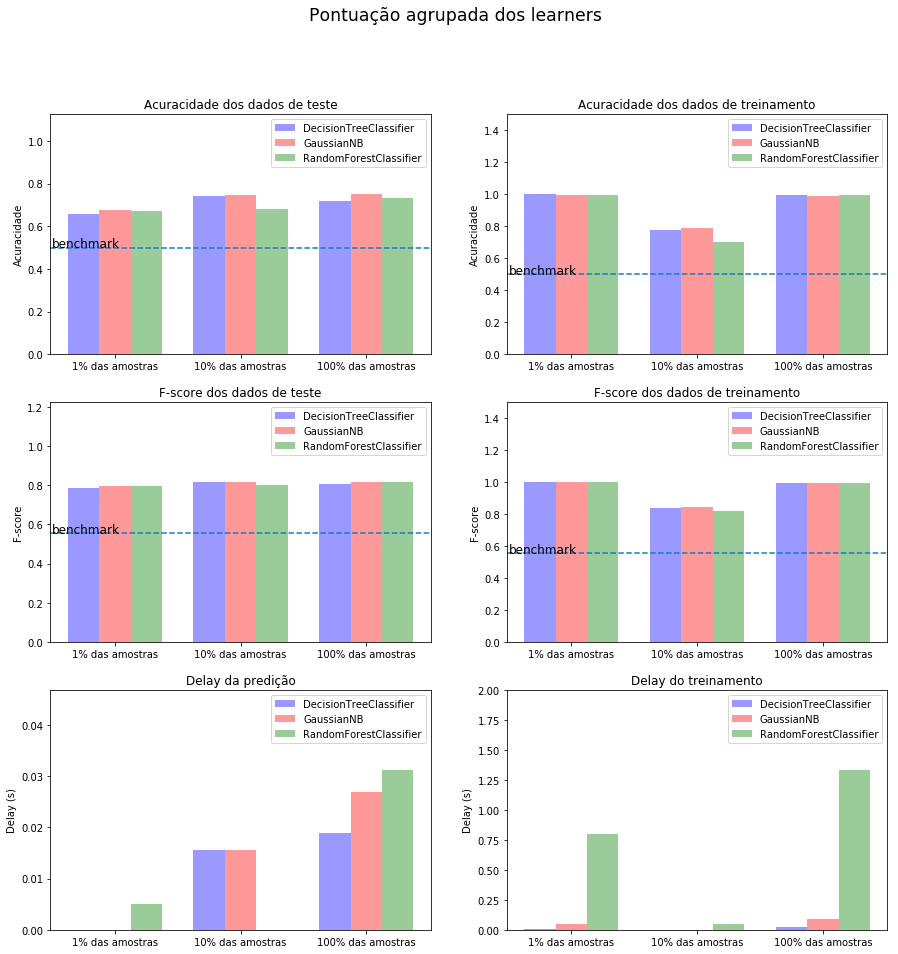

In [14]:
""" Plota a pontuação agrupada dos learners e compara com o benchmark, se tiver."""

"""
    O dataframe 'results_df' representa todas as pontuações
    calculadas para as métricas definidas em cada leaner.
"""

# Descrições das métricas na mesma sequência do dataframe 'results_df'.
name_metrics = ['Acuracidade', 'Acuracidade', 'F-score', 'F-score', 'Delay (s)', 'Delay (s)']
title_metrics = ['Acuracidade dos dados de teste', 'Acuracidade dos dados de treinamento',
                'F-score dos dados de teste', 'F-score dos dados de treinamento',
                'Delay da predição', 'Delay do treinamento']

# benchmarks das métricas na mesma sequência do dataframe 'results_df'.
benchmarks = [round(accuracy, 3), round(accuracy, 3), round(fscore, 3), round(fscore, 3), math.nan, math.nan]

# Nomes dos learner na mesma sequência do dataframe 'results_df'.
name_learners = [clf_B.__class__.__name__, clf_A.__class__.__name__, clf_C.__class__.__name__]

# Nomes dos grupos a serem agregados para cada learner.
groups = ['1% das amostras', '10% das amostras', '100% das amostras']

# Plota os resultados..
fig = plt.figure(figsize = (15,15))
for i, result in enumerate(results_df.values):
    
    # Agrupa os valores da métrica atual por percentagem de amostra e por learner.
    metric_1 = []
    metric_10 = []
    metric_100 = []
    for j in np.arange(9):
        if j>=3:
            if j>=6:
                metric_100.append(result[j])
            else:
                metric_10.append(result[j])
        else:
            metric_1.append(result[j])
    
    # Desenha o gráfico para a métrica atual.
    ax = fig.add_subplot(3, 2, i+1)
    index = np.arange(len(groups))
    bar_width = 0.25
    opacity = 0.4
    ax.bar(index, metric_1, bar_width,
           alpha=opacity, color='b',
           label=name_learners[0])
    ax.bar(index + bar_width, metric_10, bar_width,
           alpha=opacity, color='r',
           label=name_learners[1])
    ax.bar(index + 2 * bar_width, metric_100, bar_width,
           alpha=opacity, color='g',
           label=name_learners[2])
    
    # Desenha a linha que representa o benchmark para a métrica atual, se houver.
    benchmark = benchmarks[i]
    if  not math.isnan(benchmark):
        ax.axhline(y=benchmark, linestyle='--')
        ax.text(-0.25, benchmark, 'benchmark', fontsize=12)
    
    # Desenha título e valores para a métrica atual.
    ax.set_ylabel(name_metrics[i])
    ax.set_title(title_metrics[i])
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(groups)
    
    # Desenha a legenda para a métrica atual e o desloca para fora das áreas das barras já desenhadas.
    y_max = max(max(metric_1, metric_10, metric_100))
    ax.set_ylim(0.0, y_max*1.5)
    ax.legend()

# Plota os gráficos.
fig.suptitle("Pontuação agrupada dos learners", fontsize='xx-large')
plt.show()

### Escolha do melhor modelo de aprendizagem
Analisando os gráficos anteriores de pontuação agrupada dos learners, temos as seguintes respostas:
- O algoritmo 'Gaussian Naive Bayes' obteve a maior acuracidade na média dos três grupos de amostras.
- O algoritmo 'Gaussian Naive Bayes' obteve o maior f-score na média dos três grupos de amostras.
- O algoritmo 'Classifier Tree' obteve o menor delay na média dos três grupos de amostras.

Visto que a acuracidade e o f-score são mais importantes que o delay, nosso learner escolhido é o do modelo **Gaussian Naive Bayes**. Ainda segundo os gráficos, o delay para o algoritmo desse modelo é o segundo menor, viabilizando ainda mais a escolha.

----
## Refinamento
Escolhido o melhor learner, temos, então, um modelo desafinado. Agora faremos uma otimização de busca de grade para o modelo sobre todo o conjunto de treinamento ('X_train_resampled' e 'y_train_resampled'), ajustando parâmetros para melhorar a acuracidade e o f-score do modelo desafinado.

### Ajuste do modelo
Vamos ajustar o modelo escolhido usando a função de **busca de grade** 'GridSearchCV' da biblioteca 'sklearn.model_selection' com parâmetros importantes sintonizado com pelo menos 3 valores diferentes. Precisaremos usar todo o conjunto de treinamento para isso. O código a seguir compreende nos seguintes passos:

- Importação da função 'sklearn.grid_search.GridSearchCV', que fará a busca de grade.
- Importação das funções 'sklearn.metrics.make_scorer' e 'sklearn.metrics.fbeta_score', para cálculo do f-score, usando o mesmo valor anterior para beta ('0.5').
- Inicialização do classificador escolhido e atribuição para 'clf'.
- Criação de um dicionário de parâmetros que vamos ajustar para o modelo escolhido.
- Execução da busca de grade no classificador 'clf' usando o 'scorer' e atribuição em 'grid_obj'.
- Ajuste do objeto de busca de grade aos dados de treinamento ('X_train_resampled', 'y_train_resampled') e atribuição em 'grid_fit'.

In [15]:
""" Ajuste do modelo."""

from sklearn.model_selection import GridSearchCV # grid_search
from sklearn.metrics import make_scorer

# Inicialização do classificador.
clf = GaussianNB()

# Criação da lista de parâmetros alteráveis para ajustar. Neste caso, o classificador
# 'GaussianNB' somente tem um parâmetro alterável.
parameters = {'var_smoothing': [0.0, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7,
                                1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]}

# Criação de um objeto de pontuação 'fbeta_score' usando 'make_scorer()'.
scorer = make_scorer(fbeta_score, beta=0.5)

# Execução da pesquisa de grade no classificador usando 'scorer' como o método de pontuação
# usando 'GridSearchCV()'.
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer)

# Ajuste do objeto de pesquisa de grade aos dados de treinamento para encontrar
# os parâmetros ideais usando 'fit()'.
grid_fit = grid_obj.fit(X_train_resampled, y_train_resampled)

# Obtém o estimador.
best_clf = grid_fit.best_estimator_

# Realização de previsões usando o modelo não otimizado.
predictions = (clf.fit(X_train_resampled, y_train_resampled)).predict(X_test)

# Realização de previsões usando o modelo otimizado.
best_predictions = best_clf.predict(X_test)

# Relatório do antes e depois das pontuações.
print("Modelo não otimizado\n------")
print("Acuracidade sobre os dados de teste: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score sobre os dados de teste: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nModelo otimizado\n------")
print("Acuracidade final sobre os dados de teste: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score final sobre os dados de teste: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Modelo não otimizado
------
Acuracidade sobre os dados de teste: 0.6820
F-score sobre os dados de teste: 0.8005

Modelo otimizado
------
Acuracidade final sobre os dados de teste: 0.6821
F-score final sobre os dados de teste: 0.8005


A **busca de grade** é uma técnica muito utilizada para encontrar os melhores ajustes dos parâmetros de um classificador. Porém, **nem todos os parâmetros são alteráveis**. É o caso do 'GaussianNB' que tem dois, sendo um as probabilidades a priori das classes ('priors') e o outro a suavização dos dados ('var_smoothing'), mas só o segundo é alterável. O primeiro, 'prior', somente pode receber valores na inicialização do classificador. Por isso, nessa primeira tentativa de ajuste do modelo, pudemos testar apenas o parâmetro 'var_smoothing'. Contudo, não houve melhoria das métricas, mantendo as mesmas pontuações, demonstrando que os dados não precisam ser suavizados.

Ainda com o objetivo de melhorar as pontuações, resolvemos trabalhar com o parâmetro 'priors' do classificador 'GaussianNB'. Para isso não podemos usar a busca de grade pela função 'GridSearchCV()', visto que só podemos trabalhar com esse parâmetro inserindo valores na inicialização do classificador. O código a seguir faz esse processo de forma manual como uma segunda tentativa de ajustar o modelo, buscando os melhores valores para o parâmetro 'priors'. Os passos do código são:
- Determinação de um parâmetro de passo de rastreamento 'deep_tracking', com um mínimo de '1', que funcionará como um ajuste fino na busca das melhores probabilidades a priori para as duas classes conhecidas.
- Execução do rastreamento de valores das melhores probabilidades a priori com o ajuste de cada instância de 'GaussianNB' aos dados de treinamento ('X_train_resampled', 'y_train_resampled').
- Atribuição das melhores probabilidades a priori para 'best_priors' e das melhores pontuações 'accuracy_best' e 'fscore_best' com decisão a pelo fscore.
- Plotagem das probabilidades a priori das classes e seus valores de f-score.
- Relatório das melhores probabilidades a priori das classes com o melhor fscore e acuracidade em comparação com as mesmas métricas do classificador não otimizado.

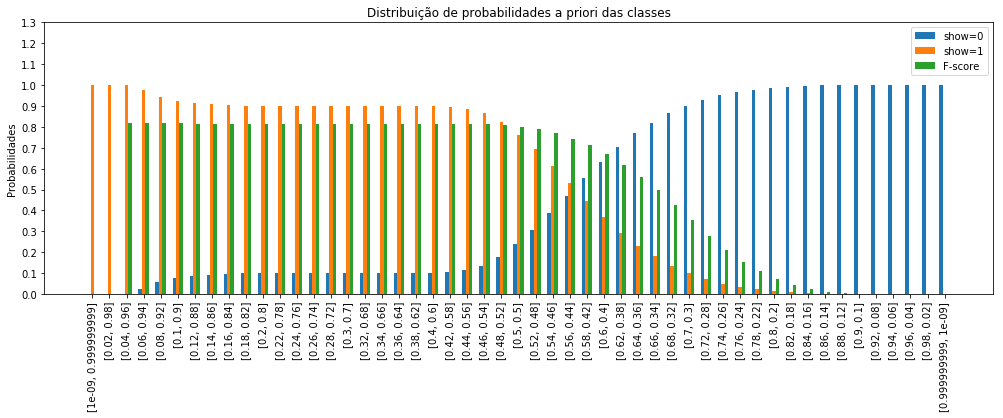

Modelo não otimizado
------
Probabilidades a priori padrão das classes:  [0.5, 0.5]
Acuracidade sobre os dados de teste: 0.6820
F-score sobre os dados de teste: 0.8005

Modelo otimizado
------
Probabilidades a priori final das classes:  [0.06, 0.94]
Acuracidade final sobre os dados de teste: 0.7759
F-score final sobre os dados de teste: 0.8186


In [47]:
""" Segunda tentativa de ajuste do modelo.
    
    Rastrea as probabilidades a priori para 
    encontrar o melhor f-score para duas classes.
"""

# Parâmetro de passo de rastreamento, entre '0.0' e '1.0', excluindo os mesmos.
step_tracking = 0.02

# Probabilidades a priori. A soma sempre será igual a '1.0'.
# O par inicial são os extremos '0.0' e '1.0'.
range_priors = [0.0, 1.0]

# Criação dos pares de probabilidades a serem testados seguindo o tamanho do passo
# de rastreamento. O último será sempre o par [1.0, 0.0].
# Exemplo 1: passo=0.4 >>> pairs_priors= [[0.0, 1.0], [0.4, 0.6], [0.8, 0.2], [1.0, 0.0]].
# Exemplo 2: passo=0.25 >>>pairs_priors= [[0.0, 1.0], [0.25, 0.75], [0.5, 0.5], [0.75, 0.25], [1.0, 0.0]].
pairs_priors = [range_priors]
min_prior = range_priors[0]
max_prior = range_priors[1]
while True:
    min_prior = round(min_prior + step_tracking, 15)
    max_prior = round(max_prior - step_tracking, 15)
    if min_prior < range_priors[1]:
        pairs_priors.append([min_prior, max_prior])
    else:
        pairs_priors.append([1.0, 0.0])
        break

# Representação de variáveis para distribuição de resultados 'classe 0' e 'classe '1'
# para as probabilidades a priori.
classes_priors = []
class_0_prob = []
class_1_prob = []
list_fscore = []

# Instancia um classificador para cada par de probabilidades a priori e testa em
# cada um deles as pontuações, sendo o f-score o mais importante.
priors_best = [1e-9, 1 - 1e-9]
accuracy_best = 0.0
fscore_best = 0.0
for pair_prior in pairs_priors:
    # Os valores de probabilidades não devem ser '0.0' e nem '1.0', pois causa
    # erro devido a obrigação de existir duas classes. Se houver, devemos alterá-los
    # para valores muito próximos deles, lembrando que também não podem ser menores
    # que '0.0' e nem maiores que '1.0'.
    if pair_prior[0] == 0.0:
        pair_prior[0] = 1e-9
        pair_prior[1] = 1 - 1e-9
    if pair_prior[0] == 1.0:
        pair_prior[0] = 1 - 1e-9
        pair_prior[1] = 1e-9

    clf_current = GaussianNB(priors=pair_prior)
    pred_current = (clf_current.fit(X_train_resampled, y_train_resampled)).predict(X_test)
    
    # Entre todos os valores de predição, deve ter pelo menos um resultado para cada
    # classe (valores '0' e '1' ao longo da lista). Se houver valores somente de uma
    # classe, as pontuações não devem ser calculadas.
    class_0_count = (list(pred_current)).count(0)
    class_1_count = (list(pred_current)).count(1)
    fscore_current = 0.0
    if class_0_count != 0 and class_1_count != 0:
        accuracy_current = accuracy_score(y_test, pred_current)
        fscore_current = fbeta_score(y_test, pred_current, beta = 0.5)
        if fscore_best <= fscore_current :
            priors_best = pair_prior
            accuracy_best = accuracy_current
            fscore_best = fscore_current
    else:
        fscore_current = 0.0
    list_fscore.append(fscore_current)
    
    # Atribui as quantidades de classes para cada probabilidades a priori.
    y_test_total = y_test.shape[0]
    classes_priors.append(str(pair_prior))
    class_0_prob.append(class_0_count/y_test_total)
    class_1_prob.append(class_1_count/y_test_total)

# Plota a distribuição de resultados 'classe 0' e 'classe 1' para as probabilidades a priori.
plt.figure(figsize = (17,5))
ind = np.arange(len(classes_priors))    # the x locations for the groups
width = 0.2       # the width of the bars: can also be len(x) sequence
p1 = plt.bar(ind-width/2, class_0_prob, -width, align='edge')
p2 = plt.bar(ind, class_1_prob, width)
p3 = plt.bar(ind+width/2, list_fscore, width, align='edge')
plt.ylabel('Probabilidades')
plt.title('Distribuição de probabilidades a priori das classes')
plt.xticks(ind, classes_priors, rotation='vertical')
plt.yticks(np.arange(0, 1.4, 0.1))
plt.legend((p1[0], p2[0], p3[0]), ('show=0', 'show=1', 'F-score'))
plt.show()

# Relatório do antes e depois das pontuações.
print("Modelo não otimizado\n------")
print("Probabilidades a priori padrão das classes: ", list(clf.class_prior_))
print("Acuracidade sobre os dados de teste: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score sobre os dados de teste: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nModelo otimizado\n------")
print("Probabilidades a priori final das classes: ", priors_best)
print("Acuracidade final sobre os dados de teste: {:.4f}".format(accuracy_best))
print("F-score final sobre os dados de teste: {:.4f}".format(fscore_best))

### Avaliação do modelo final
Com os últimos valores de pontuação, encontramos nosso modelo final com o valor de parâmetro 'step_tracking=0.02' e nosso par de prioridades a priori 'priors=(0.06, 0.94)'. Além disso, observando o gráfico acima, onde o f-score praticamente acompanha o resultado 'show=1', podemos dizer que os registros das features que resulta no paciente comparecendo à consulta ajuda mais o modelo a prever corretamente. Ficamos com a seguinte comparação:

**Resultados**:

|    Métricas    |  Modelo Não Otimizado  | Modelo Otimizado |
| :------------: | :--------------------: | :--------------: | 
| Acuracidade    |          0.6820        |       0.7759     |
| F-score        |          0.8005        |       0.8186     |

Os códigos que representam nosso modelo final são:
- Instanciação do modelo de aprendizagem: **Modelo_Final = GaussianNB(priors = (0.06, 0.94))**.
- Ajuste do modelo final aos dados: **Modelo_Final_Ajustado = Modelo_Final.fit(X_train_resampled, y_train_resampled)**.
- Função preditora: **Resultado = Modelo_Final_Ajustado.predict(Dados_Features)**, onde 'Dados_Features' é um dataframe com os dados de todas as features com pelo menos um pacientes e 'Resultado' é um valor '1' (show) ou 0' (no-show) retornado.

----
## Importância das features

É importante determinar quais features fornecem a maior capacidade de previsão ao realizar o aprendizado supervisionado em um conjunto de dados. Nesse projeto, podemos identificar as features que prevejam com maior intensidade se um paciente vai comparecer ou não à consulta. Para isso, temos que usar um classificador da biblioteca 'sklearn' que tenha o atributo 'feature_importance_'. Esse atributo retorna os valores de importância, ou seja, pesos nos resultados, para cada feature features de acordo com o classificador escolhido. Nosso modelo final, que usa o classificador 'GaussianNB' não possui esse atributo. Como nossa tarefa nesta seção é inicialmente saber as importâncias das features, podemos usar qualquer outro classificador que tenha esse atributo.

### Extração das importâncias das features
Para sabermos os pesos das features nos resultados, vamos usar, dentre outros, o classificador **RandomForestClassifier** nos mesmos dados de treinamento usado no nosso modelo final. No código a seguir, vamos implementar o seguinte:
- Inicialização do modelo de aprendizagem 'RandomForestClassifier'.
- Ajuste do modelo supervisionado em todo o conjunto de dados de treinamento.
- Extração das pesos das features usando '.feature_importances_'.
- Plotagem das features com seus pesos em ordem decrescente e os pesos acumulados em ordem crescente.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


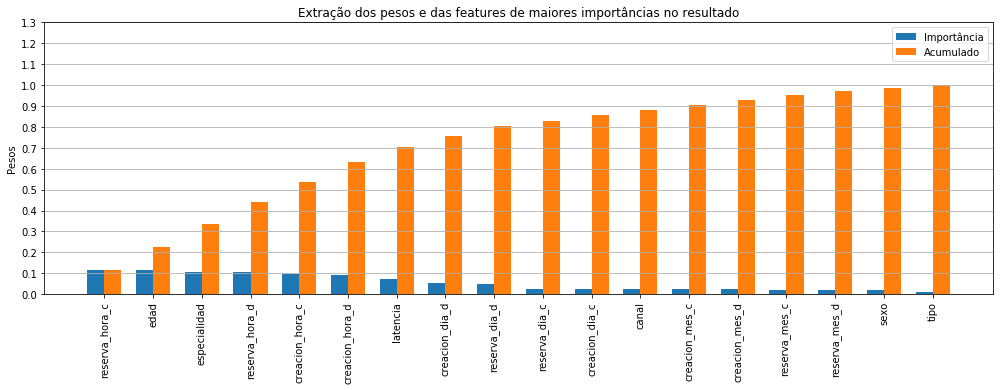

In [48]:
""" Extração dos pesos e das features de maiores importâncias no resultado."""

from operator import itemgetter

# Inicialização do modelo de aprendizagem.
clf_importances = RandomForestClassifier()

# Ajuste do modelo supervisionado em todo o conjunto de dados de treinamento.
model = clf_importances.fit(X_train_resampled, y_train_resampled)

# Extração das pesos das features.
importances = model.feature_importances_

# Ordenação decrescente dos resultados.
importances_sort_decr = dict(zip(range(len(importances)), importances))
importances_sort_decr = importances_sort_decr.items()
importances_sort_decr = dict(sorted(importances_sort_decr, key = itemgetter(1), reverse=True))
weight_decr = importances_sort_decr.values()
accum_cresc = []
names_features = X_train_resampled.columns
names_features_decr = []
weight_accum = 0.0
for index in importances_sort_decr:
    weight_accum = weight_accum + importances_sort_decr[index]
    accum_cresc.append(weight_accum)
    names_features_decr.append(names_features[index])

# Plotagem das features com seus pesos em ordem decrescente e os pesos
# acumulados em ordem crescente.
plt.figure(figsize = (17,5))
ind = np.arange(X_train_resampled.shape[1])    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence
p1 = plt.bar(ind, weight_decr, -width, align='edge')
p2 = plt.bar(ind, accum_cresc, width, align='edge')
plt.grid(True, axis='y')
plt.ylabel('Pesos')
plt.title('Extração dos pesos e das features de maiores importâncias no resultado')
plt.xticks(ind, names_features_decr, rotation='vertical')
plt.yticks(np.arange(0, 1.4, 0.1))
plt.legend((p1[0], p2[0]), ('Importância', 'Acumulado'))
plt.show()

### Seleção das features mais importantes
Com menos features necessárias para treinar, a expectativa é que o tempo de treinamento e previsão seja muito menor. A partir da visualização no gráfico acima, vemos que o acumulado das nove features de maiores pesos contribuem com mais de 80% da importância no resultado, percebendo que são metade de todas as features. Isso sugere que podemos tentar **reduzir o espaço de features** e simplificar as informações necessárias para o modelo aprender. O código a seguir treinará o modelo final com o mesmo conjunto de dados de treinamento **com apenas as nove features mais importantes**. Também treinará com todas elas somente para coletar o delay.

In [49]:
""" Modelo final aplicado ao conjunto de dados com as features mais importantes."""

# Redução do espaço de features de dezoito para nove (os mais importantes).
X_train_reduced = X_train_resampled[X_train_resampled.columns.values[(np.argsort(importances)[::-1])[:9]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:9]]]

# Modelo final.
clf = GaussianNB(priors = (0.06, 0.94))

# Treinamento do modelo final com os dados completos.
time_clf_full = time()
clf.fit(X_train_resampled, y_train_resampled)
full_predictions = clf.predict(X_test)
time_clf_full = time() - time_clf_full

# Treinamento do modelo final com os dados reduzidos.
time_clf_reduced = time()
clf.fit(X_train_reduced, y_train_resampled)
reduced_predictions = clf.predict(X_test_reduced)
time_clf_reduced = time() - time_clf_reduced

# Relatório de pontuações do modelo final usando as duas versões de dados.
print("As nove features mais importantes em ordem decrescente de peso\n------\n", names_features_decr[:9])
print("\nModelo treinado nos dados completos\n------")
print("Delay de treinamento: {:.4f}s".format(time_clf_full))
print("Acuracidade nos dados de teste: {:.4f}".format(accuracy_score(y_test, full_predictions)))
print("F-score nos dados de teste: {:.4f}".format(fbeta_score(y_test, full_predictions, beta = 0.5)))
print("\nModelo final treinado nos dados reduzidos\n------")
print("Delay de treinamento: {:.4f}s".format(time_clf_reduced))
print("Acuracidade nos dados de teste: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score nos dados de teste: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

As nove features mais importantes em ordem decrescente de peso
------
 ['reserva_hora_c', 'edad', 'especialidad', 'reserva_hora_d', 'creacion_hora_c', 'creacion_hora_d', 'latencia', 'creacion_dia_d', 'reserva_dia_d']

Modelo final treinado nos dados completos
------
Delay de treinamento: 0.0520s
Acuracidade nos dados de teste: 0.7759
F-score nos dados de teste: 0.8186

Modelo final treinado nos dados reduzidos
------
Delay de treinamento: 0.0312s
Acuracidade nos dados de teste: 0.7820
F-score nos dados de teste: 0.8176


Com os valores preditos usando apenas as nove features mais importantes, percebemos que a acuracidade e o f-score tiveram reduções insignificantes em relação ao modelo final não reduzido, da ordem de alguns milésimos, continuando acima dos valores de benchmark, do modelo não otimizado e do modelo otimizado. Em contrapartida, o tempo de treinamento do classificador diminuiu em torno da metade. Portanto, podemos considerar que **a redução de features obteve resultados validados**.

----
## Resultados finais
Instanciação para o modelo final do classificador de aprendizado supervisionado:
- GaussianNB(priors = (0.06, 0.94)).

Features mais importantes em ordem decrescente de peso:
- 'reserva_hora_d', 'edad', 'especialidad', 'creacion_hora_d', 'creacion_hora_c', 'reserva_hora_c', 'latencia', 'creacion_dia_d' e 'reserva_dia_d'.

Benchmark das pontuações:
- Acuracidade = 0.5000
- F-score = 0.5556

Pontuações do modelo final com as nove features mais importantes:
- Acuracidade = 0.7820
- F-score = 0.8176